In [1]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers import concatenate,Reshape,Add,LSTM,Multiply
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Bidirectional, LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam, RMSprop

from keras import Model
from keras import Input
from keras.callbacks import ModelCheckpoint

import cython
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from time import time
from gensim.models import Word2Vec
from keras.initializers import Constant
from keras.utils import to_categorical
from keras.preprocessing.text import text_to_word_sequence,Tokenizer
from keras.preprocessing.sequence import pad_sequences,TimeseriesGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 


Using TensorFlow backend.


# Внимание! 

Если планируете запускать весь ноутбук, то убедитесь, что количество озу в вашем пека >=32 гб. Либо коллаб в помощь

### Загрузим данные

размер словаря - 84267 слов,количество предложений - 73477, максимальная длинна текста - 398 символов, максимальное количество слов в предложении - 190


In [2]:
data=np.array(pd.read_csv('data.csv'))

### Проведем токенизацию

То есть разобьем исходные предложения на слова

In [3]:
def processText(data):
    tokens=[]
    for line in data:
        newToken=text_to_word_sequence(text=line[2],filters='!"#$%&amp;()*+,-./:;&lt;=>?@[\\]^_`{|}~\t\n\ufeff',
                                  lower=True,split=' ')
        tokens.append(newToken)
    return tokens

In [4]:
wordLists=processText(data)
print(wordLists[0])

['любые', 'разногласия', 'во', 'мнениях', 'скоро', 'улягутся', 'а', 'вы', 'продолжайте', 'делать', 'как', 'делали', 'но', 'постарайтесь', 'не', 'наступать', 'на', 'ноги', 'слишком', 'многим', 'иначе', 'ваши', 'сегодняшние', 'действия', 'сыграют', 'против', 'вас', 'в', 'будущем']


### Заменим слова в предложениях на соответсвующие в словаре индексы

In [5]:
num_words = 20000 #84267
tokenizer = Tokenizer(
    num_words=num_words,
    filters='!"#$%&amp;()*+,-—./:;&lt;=>?@[\\]^_`{|}~\t\n\xa0\ufeff',
    lower=True,
    split=' ',
    char_level=False) 


tokenizer.fit_on_texts(wordLists) 
sequences = np.array(tokenizer.texts_to_sequences(wordLists))
print(sequences[0])

[293, 448, 66, 8385, 4715, 15933, 22, 8, 10529, 336, 34, 10057, 25, 127, 3, 16752, 7, 12640, 169, 755, 254, 43, 3549, 279, 4619, 953, 12, 2, 614]


### Зафиксируем характеристики выборки

In [6]:
sentLen = len(max(sequences, key = len)) # max_len
word2index = tokenizer.word_index       #word_index
wordsNum = len(tokenizer.word_index) + 1 # num_words
embeddingDim=300

### Дополним предожения нулями до одной длины

In [7]:
sequences = pad_sequences(sequences = sequences, maxlen = sentLen,padding='post')
print(sequences[0])
print(sequences[0].shape)
print(sequences.shape)

[  293   448    66  8385  4715 15933    22     8 10529   336    34 10057
    25   127     3 16752     7 12640   169   755   254    43  3549   279
  4619   953    12     2   614     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [ ]:
w2v = Word2Vec.load("word2vec.model")

In [ ]:
embeddingMatrix = np.zeros((wordsNum, embeddingDim))
for word, i in tokenizer.word_index.items():
    if i > wordsNum: #если индекс превышает кол-во слов в словаре, то скипаем  
        continue
    embeddingVector = w2v[word] #получаем вектор соответствущий слову в модели word2vec
    if embeddingVector is not None:  #если слово отсутствует в словаре word2vec, то оно в матрице np.zeroes останется равным 0
        embeddingMatrix[i] = embeddingVector #если слово найдено в словаре токенизатора, то в embedding_matrix проставляем вектор соответствующий слову

### Отнормируем вектора embedding'ов. 

In [ ]:
scaler=MinMaxScaler((-2,2))

До нормализации

In [ ]:
embeddingMatrix[458][:40]

In [ ]:
embeddingMatrix=scaler.fit_transform(embeddingMatrix)

In [ ]:
w2v.init_sims(replace=True)

После нормализации

In [ ]:
embeddingMatrix[458][:40]

### Приведем датасет к специальному виду

 Например для текста "The sky was falling due to apocalypse " будет
 
 "The sky" -> was
 
 "sky was" -> falling
 
 " was falling " -> due 
 
 " falling due" -> to
 
 "due to " -> apocalypse
 


In [8]:
def word2idx(word):
    return w2v.wv.vocab[word].index
def idx2word(idx):
    return w2v.wv.index2word[idx]

In [9]:
seqlen=10
step=1
inputSent = []
labelSent = []
count=0
N=500000
for i,line in enumerate(sequences):
    if count>=N:
        break
    for j in range(0, len(line) - step, step):
        count+=1
        inputSent.append(line[j])
        labelSent.append(line[j + step])

In [10]:
inputSent[0:5]

[293, 448, 66, 8385, 4715]

In [11]:
labelSent[0:4]


[448, 66, 8385, 4715]

In [12]:
sentStep=3
X=np.zeros((len(inputSent),3))
for i in range(len(inputSent)-2):
    X[i]=(inputSent[i],inputSent[i+1],inputSent[i+2])

Соотнесем кадому слову из выборки Y вектор embedding'а

In [13]:

Y=np.zeros((X.shape[0],num_words),dtype='bool')


In [ ]:
#Y=to_categorical(labelSent)

In [14]:
for i,line in enumerate(Y):
    index=labelSent[i]
    line[index]=1

In [ ]:
for i,index in enumerate(labelSent):
    Y[i]=w2v[idx2word(index)]

In [ ]:
Y=scaler.fit_transform(Y)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.01,shuffle=False) #, random_state = 42)

In [ ]:
del X

In [ ]:
del Y

In [ ]:
del x_train
del y_train
del x_test
del y_test

In [ ]:
np.save('x_train.npy',x_train)
np.save('y_train.npy',y_train)
np.save('x_test.npy',x_test)
np.save('y_test.npy',y_test)

In [ ]:
x_train=np.load('x_train.npy')
x_test=np.load('x_test.npy')
y_train=np.load('y_train.npy')
y_test=np.load('y_test.npy')

In [ ]:
x_train[0]

## Раздел "спасите, не работает"

Поставлена задача по входному эмбеддингу слова определить эмбеддинг следующего слова, то есть - задача регресси. Однако по факту ничего не работает. 

Либо модель плохая (да), либо оптимизатор плохой (да) и все в таком духе.

Варианты с GRU, SLTM не работают.

Протестированы регрессионные функции потерь: косинусная метрика, среднеквадратичная 

In [25]:
modelGRU = Sequential()
#embedding_layer = w2v.wv.get_keras_embedding(train_embeddings=False)
modelGRU.add(Embedding(input_dim = num_words+1, 
                              output_dim = embeddingDim, 
                              
                              input_length =sentStep, 
                             ))
#modelGRU.add(Embedding(num_words, embedding_size))
#modelGRU.add(SpatialDropout1D(0.2))
modelGRU.add(Bidirectional(GRU(128, return_sequences=True)))
modelGRU.add(Bidirectional(GRU(256)))
#modelGRU.add(Bidirectional(LSTM(128)))
#modelGRU.add(LSTM(8,return_sequences=True ))
#modelGRU.add(LSTM(128))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(64))
modelGRU.add(LeakyReLU(0.2))

modelGRU.add(Dense(num_words,activation = 'softmax'))
modelGRU.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 3, 300)            6000300   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 3, 256)            329472    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 512)               787968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20000)            

In [17]:
optimizer=RMSprop(0.001)
checkpoint = ModelCheckpoint(
    'output/{val_acc:.4f}.hdf5',
    monitor='val_acc',
    verbose=1, 
    save_best_only=True,
    mode='auto')

In [26]:
modelGRU.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["categorical_accuracy"])
historyGRU = modelGRU.fit(x_train, y_train, batch_size=2048, epochs=20, validation_split=0.05, verbose=1)

Train on 470285 samples, validate on 24752 samples
Epoch 1/20
470285/470285 [==============================] - 150s 318us/step - loss: 2.4250 - categorical_accuracy: 0.6892 - val_loss: 1.8846 - val_categorical_accuracy: 0.7252
Epoch 2/20
470285/470285 [==============================] - 149s 318us/step - loss: 1.7279 - categorical_accuracy: 0.7367 - val_loss: 1.2771 - val_categorical_accuracy: 0.7804
Epoch 3/20
470285/470285 [==============================] - 149s 316us/step - loss: 1.1845 - categorical_accuracy: 0.8007 - val_loss: 0.8898 - val_categorical_accuracy: 0.8350
Epoch 4/20
470285/470285 [==============================] - 149s 316us/step - loss: 0.9343 - categorical_accuracy: 0.8382 - val_loss: 0.7141 - val_categorical_accuracy: 0.8713
Epoch 5/20
470285/470285 [==============================] - 148s 314us/step - loss: 0.7927 - categorical_accuracy: 0.8640 - val_loss: 0.5886 - val_categorical_accuracy: 0.8986
Epoch 6/20
470285/470285 [==============================] - 148s 316u

In [ ]:
import matplotlib.pyplot as plt

In [27]:
modelGRU.save_weights('modelGRU.h5')

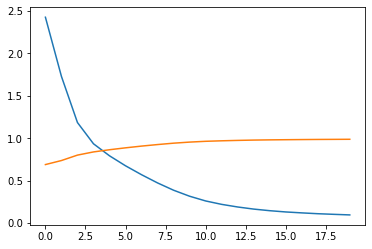

In [30]:
plt.plot(historyGRU.history['loss'])
plt.plot(historyGRU.history['categorical_accuracy'])

In [129]:
n=20
words=['Деньги раки весы']
newWords=np.zeros((1,3))
sentences = np.array(tokenizer.texts_to_sequences(words))
newWords[0]=(sentences[0][0],sentences[0][1],sentences[0][2])
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print(words)
for i in range(n):
    res=modelGRU.predict(newWords)
    nextIndex=res.argmax()
    predWord=reverse_word_map[nextIndex]
    print(predWord)
    for j in range(newWords.shape[1]-1):
        newWords[0][j]=newWords[0][j+1]
    newWords[0][2]=nextIndex
    print(nextIndex)
    

['Деньги раки весы']
прибыль
589
весы
923
прибыль
589
весы
923
прибыль
589
весы
923
прибыль
589
весы
923
прибыль
589
весы
923
прибыль
589
весы
923
прибыль
589
весы
923
прибыль
589
весы
923
прибыль
589
весы
923
прибыль
589
весы
923
